In [2]:
import xtrack as xt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xpart as xp
import xobjects as xo
import yaml
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import curve_fit

/eos/user/a/aradosla/.local/lib/python3.9/site-packages/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Now we want to start tracking particles!
First of all let's load the collider and build the trackers.

Then we want to set the optics from a config file.
We will use the optics from the HL-LHC config.

In [3]:
collider = xt.Multiline.from_json('data/collider_thin.json')
collider.build_trackers()

Xfields not installed correctly


Loading line from dict:   0%|          | 0/23700 [00:00<?, ?it/s]

Xfields not installed correctly


Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Xfields not installed correctly


Done loading line from dict.           


Loading line from dict:   0%|          | 0/23700 [00:00<?, ?it/s]

Xfields not installed correctly


Done loading line from dict.           


Loading line from dict:   0%|          | 0/23704 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [4]:
with open('data/config.yaml', "r") as fid:
        config = yaml.safe_load(fid)
    
def set_orbit_from_config(collider, config):

    print('Setting optics as from config')
    for ii in ['on_x1', 'on_sep1', 'on_x2', 'on_sep2', 'on_x5',
               'on_sep5', 'on_x8h', 'on_x8v', 'on_sep8h', 'on_sep8v',
               'on_a1', 'on_o1', 'on_a2', 'on_o2', 'on_a5', 'on_o5', 'on_a8', 
               'on_o8', 'on_disp', 'on_crab1', 'on_crab5', 'on_alice_normalized', 
               'on_lhcb_normalized', 'on_sol_atlas', 'on_sol_cms', 'on_sol_alice', 
               'vrf400', 'lagrf400.b1', 'lagrf400.b2']:
        if "on_crab" in ii:
             collider.vars[ii] = 0
        #if 'on' in ii:
        #    collider.vars[ii] = 0
        
        else:
            collider.vars[ii] = config['config_collider']['config_knobs_and_tuning']['knob_settings'][ii]
set_orbit_from_config(collider, config)
twiss_b1 = collider['lhcb1'].twiss(method ='4d', freeze_longitudinal = True)
line = collider['lhcb1']
line.cycle(f"ip3", inplace=True)

''' 
for ii in line.elements:
   # if ii is a type 'multipole' 
   
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0
'''


Setting optics as from config
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


" \nfor ii in line.elements:\n   # if ii is a type 'multipole' \n   \n    if type(ii) == xt.beam_elements.elements.Multipole:\n        if len(ii.knl)>2:\n            #print(ii)\n            ii.knl[2] = 0\n"

Text(0.5, 1.0, 'Closed orbit')

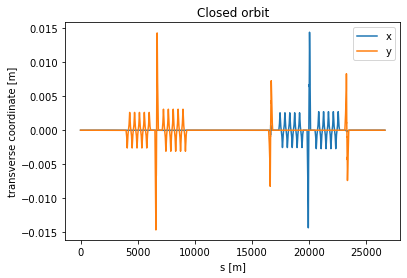

In [5]:
tw0 = collider.lhcb1.twiss()
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])

fig, ax = plt.subplots()
plt.plot(tw0.s, tw0.x, label='x')
plt.plot(tw0.s, tw0.y, label='y')
plt.legend()
plt.xlabel('s [m]')
plt.ylabel('transverse coordinate [m]')
plt.title('Closed orbit')

In [6]:
ctx = xo.ContextCpu()
N_particles = 10000
bunch_intensity = 2.2e11
normal_emitt_x = 2.5e-6 #m*rad
normal_emitt_y = 2.5e-6 #m*rad
sigma_z = 7.5e-2 
particle_ref = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
gaussian_bunch = xp.generate_matched_gaussian_bunch(
        num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = line)

#gaussian_bunch.zeta = 0.0
#gaussian_bunch.delta = 0.0

*** Maximum RMS bunch length 0.11789499136495381m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4968e-02
... distance to target bunch length: 8.3248e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3351e-04
... distance to target bunch length: -2.3601e-05
... distance to target bunch length: 1.8475e-07
... distance to target bunch length: -1.8174e-07
--> Bunch length: 0.07499981825523187
--> Emittance: 2.127522469337448


In [7]:
tw0 = collider['lhcb1'].twiss()
sigma_x = float(np.std(gaussian_bunch.x))
sigma_delta = float(np.std(gaussian_bunch.delta))
geom_emittance = (sigma_x**2-(tw0[:,0]["dx"][0]*sigma_delta)**2)/tw0[:,0]["betx"][0]
norm_emittance = geom_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
norm_emittance

2.55653149181447e-06

## Colored distribution function and generation

In [8]:
# Read the data generated by the colored distribution code 

df_colored = pd.read_parquet('initial_distribution.parquet')

In [9]:
# Fucntion for mathed gaussian generation

def generate_matched_gaussian_bunch_colored(num_particles,
                                    nemitt_x, nemitt_y, sigma_z,
                                    total_intensity_particles=None,
                                    particle_on_co=None,
                                    R_matrix=None,
                                    circumference=None,
                                    momentum_compaction_factor=None,
                                    rf_harmonic=None,
                                    rf_voltage=None,
                                    rf_phase=None,
                                    p_increment=0.,
                                    tracker=None,
                                    line=None,
                                    particle_ref=None,
                                    particles_class=None,
                                    engine=None,
                                    _context=None, _buffer=None, _offset=None,
                                    **kwargs, # They are passed to build_particles
                                    ):

    """
    Generate a matched Gaussian bunch.

    Parameters
    ----------
    line : xpart.Line
        Line for which the bunch is generated.
    num_particles : int
        Number of particles to be generated.
    nemitt_x : float
        Normalized emittance in the horizontal plane (in m rad).
    nemitt_y : float
        Normalized emittance in the vertical plane (in m rad).
    sigma_z : float
        RMS bunch length in meters.
    total_intensity_particles : float
        Total intensity of the bunch in particles.

    Returns
    -------
    part : xpart.Particles
        Particles object containing the generated particles.

    """

    if line is not None and tracker is not None:
        raise ValueError(
            'line and tracker cannot be provided at the same time.')

    if tracker is not None:
        print(
            "The argument tracker is deprecated. Please use line instead.",
            DeprecationWarning)
        line = tracker.line

    if line is not None:
        assert line.tracker is not None, ("The line has no tracker. Please use "
                                          "`Line.build_tracker()`")

    if (particle_ref is not None and particle_on_co is not None):
        raise ValueError("`particle_ref` and `particle_on_co`"
                " cannot be provided at the same time")

    if particle_ref is None:
        if particle_on_co is not None:
            particle_ref = particle_on_co
        elif line is not None and line.particle_ref is not None:
            particle_ref = line.particle_ref
        else:
            raise ValueError(
                "`line`, `particle_ref` or `particle_on_co` must be provided!")

    zeta, delta = xp.generate_longitudinal_coordinates(
            distribution='gaussian',
            num_particles=num_particles,
            particle_ref=(particle_ref if particle_ref is not None
                          else particle_on_co),
            line=line,
            circumference=circumference,
            momentum_compaction_factor=momentum_compaction_factor,
            rf_harmonic=rf_harmonic,
            rf_voltage=rf_voltage,
            rf_phase=rf_phase,
            p_increment=p_increment,
            sigma_z=sigma_z,
            engine=engine,
            **kwargs)

    assert len(zeta) == len(delta) == num_particles

    x_norm = df_colored['x'].values
    px_norm = df_colored['px'].values
    y_norm = df_colored['y'].values
    py_norm = df_colored['py'].values

    if total_intensity_particles is None:
        # go to particles.weight = 1
        total_intensity_particles = num_particles


    part = xp.build_particles(_context=_context, _buffer=_buffer, _offset=_offset,
                      R_matrix=R_matrix,
                      particles_class=particles_class,
                      particle_on_co=particle_on_co,
                      particle_ref=(
                          particle_ref if particle_on_co is  None else None),
                      line=line,
                      zeta=zeta, delta=delta,
                      x_norm=x_norm, px_norm=px_norm,
                      y_norm=y_norm, py_norm=py_norm,
                      nemitt_x=nemitt_x, nemitt_y=nemitt_y,
                      weight=total_intensity_particles/num_particles,
                      **kwargs)
    return part


In [10]:
# Use the matched colored gaussian function

gaussian_bunch_colored = generate_matched_gaussian_bunch_colored(num_particles = N_particles, total_intensity_particles = bunch_intensity,
        nemitt_x = normal_emitt_x, nemitt_y=normal_emitt_y, sigma_z = sigma_z,
        particle_ref = particle_ref,
        line = line)

*** Maximum RMS bunch length 0.11789499136495381m.
... distance to target bunch length: -7.5000e-02
... distance to target bunch length: 3.9638e-02
... distance to target bunch length: 3.4968e-02
... distance to target bunch length: 8.3248e-03
... distance to target bunch length: -1.1693e-02
... distance to target bunch length: 8.3351e-04
... distance to target bunch length: -2.3601e-05
... distance to target bunch length: 1.8475e-07
... distance to target bunch length: -1.8174e-07
--> Bunch length: 0.07499981825523187
--> Emittance: 2.127522469337448


/tmp/ipykernel_2418/1432412640.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_colored['x'],df_colored['weights'], cmap='viridis', alpha=0.5)


(array([  0.,  50., 100., 150., 200., 250.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250')])

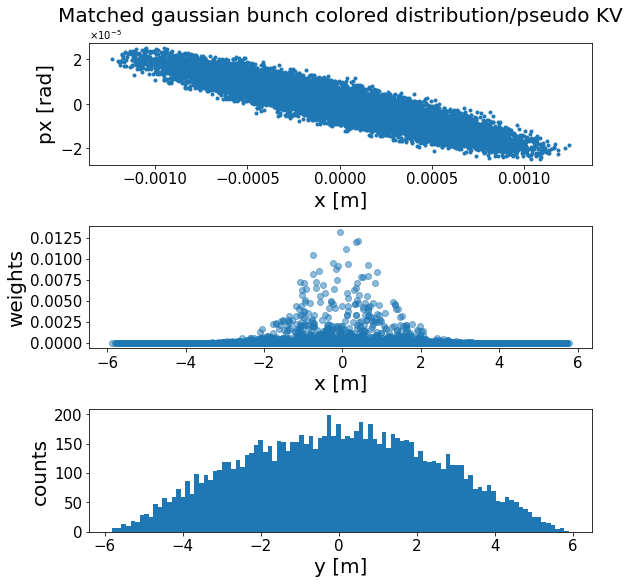

In [12]:
starting_x_c = ctx.nparray_from_context_array(gaussian_bunch_colored.x).copy()
fontsize = 20

fig = plt.figure()
plt.subplot(3,1,1)
fig.set_size_inches(9, 9)
plt.plot(gaussian_bunch_colored.x, gaussian_bunch_colored.px, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('px [rad]', fontsize = fontsize)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, 3))  # Adjust as needed
plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().tick_params(axis='both', which='both', labelsize=15)
plt.title('Matched gaussian bunch colored distribution/pseudo KV', fontsize = fontsize)

plt.subplot(3,1,2)
plt.scatter(df_colored['x'],df_colored['weights'], cmap='viridis', alpha=0.5)
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('weights', fontsize = fontsize)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.subplots_adjust(hspace=0.5)

plt.subplot(3,1,3)
plt.hist(df_colored['y'], bins=100)
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('counts', fontsize = fontsize)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


## GOBACK to Gaussian: Let's plot the bunch in the transverse plane and the histogram of the particles.

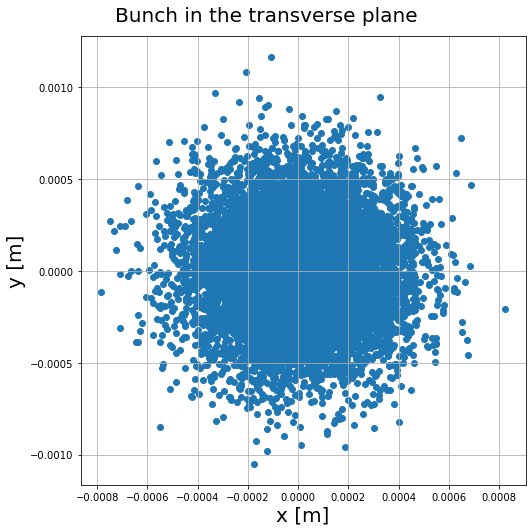

In [13]:
starting_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
starting_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
starting_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(7.5, 7.5)
fontsize = 20
fig.suptitle('Bunch in the transverse plane', fontsize = fontsize)
ax.scatter(starting_x, starting_y)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.set_ylabel('y [m]', fontsize = fontsize)
ax.grid()
plt.tight_layout()

## Example: starting distribution gaussian fit

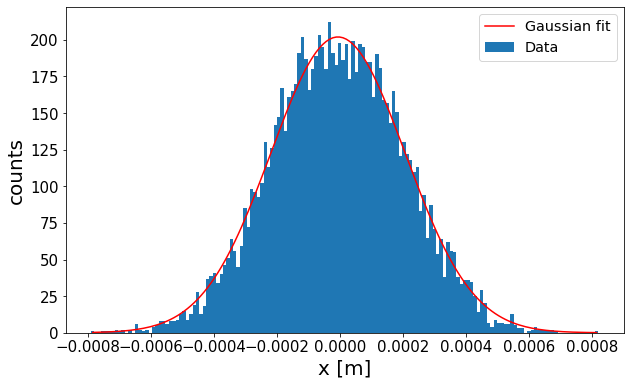

In [14]:
hist, bin_edges = np.histogram(starting_x, bins = 150)

counts = hist

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

# One can do that automatically
initial_guess = [250., 0., 1e-4]

fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

# Extract fitted parameters
amplitude_fit, mean_fit, stddev_fit = fit_params

# Generate the fitted Gaussian curve
y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)

plt.figure(figsize=(10,6))
plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit', color='red')
plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], label='Data')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('counts', fontsize = fontsize)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)

plt.legend(fontsize = 'x-large')

Let's track the bunch for some turns along the collider.

Then we compare the starting and ending distributions. We will see that the distribution changes, as expected.

## Example: initial distribution emittance

In [15]:
gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])
sigma_delta: float = float(np.std(gaussian_bunch.delta))

sigma_x: float = float(np.std(gaussian_bunch.x))
sigma_y: float = float(np.std(gaussian_bunch.y))
geom_epsx: float = (sigma_x**2 - (twiss_b1.dx[0] * sigma_delta)**2) / twiss_b1.betx[0]
geom_epsy: float = (sigma_y**2 - (twiss_b1.dy[0] * sigma_delta)**2) / twiss_b1.bety[0]

print('Emittance geometrical x = ', geom_epsx)

norm_emitt_x = geom_epsx * particle_ref._gamma0[0]  * particle_ref._beta0[0]
norm_emitt_y = geom_epsy * particle_ref._gamma0[0]  * particle_ref._beta0[0]

print('Emittance normalized x = ', norm_emitt_x)

geom_epsy_fit: float = (stddev_fit**2 - (twiss_b1.dy[0] * sigma_delta)**2) / twiss_b1.bety[0]
norm_emitt_x_fit = geom_epsx * particle_ref._gamma0[0]  * particle_ref._beta0[0]

print('Emittance normalized x fit = ', norm_emitt_x_fit)

print(betx_rel)
print(gamma_rel)

Emittance geometrical x =  3.4266498067865376e-10
Emittance normalized x =  2.5564597662769543e-06
Emittance normalized x fit =  2.5564597662769543e-06
0.9999999910167907
7460.522473526161


In [16]:
N_turns = 20
line.track(gaussian_bunch, num_turns = N_turns, turn_by_turn_monitor=True, freeze_longitudinal=True)

''' 
for i in range(N_turns):
    line.track(gaussian_bunch, num_turns = 1, turn_by_turn_monitor=True, freeze_longitudinal=True)


'''

' \nfor i in range(N_turns):\n    line.track(gaussian_bunch, num_turns = 1, turn_by_turn_monitor=True, freeze_longitudinal=True)\n\n\n'

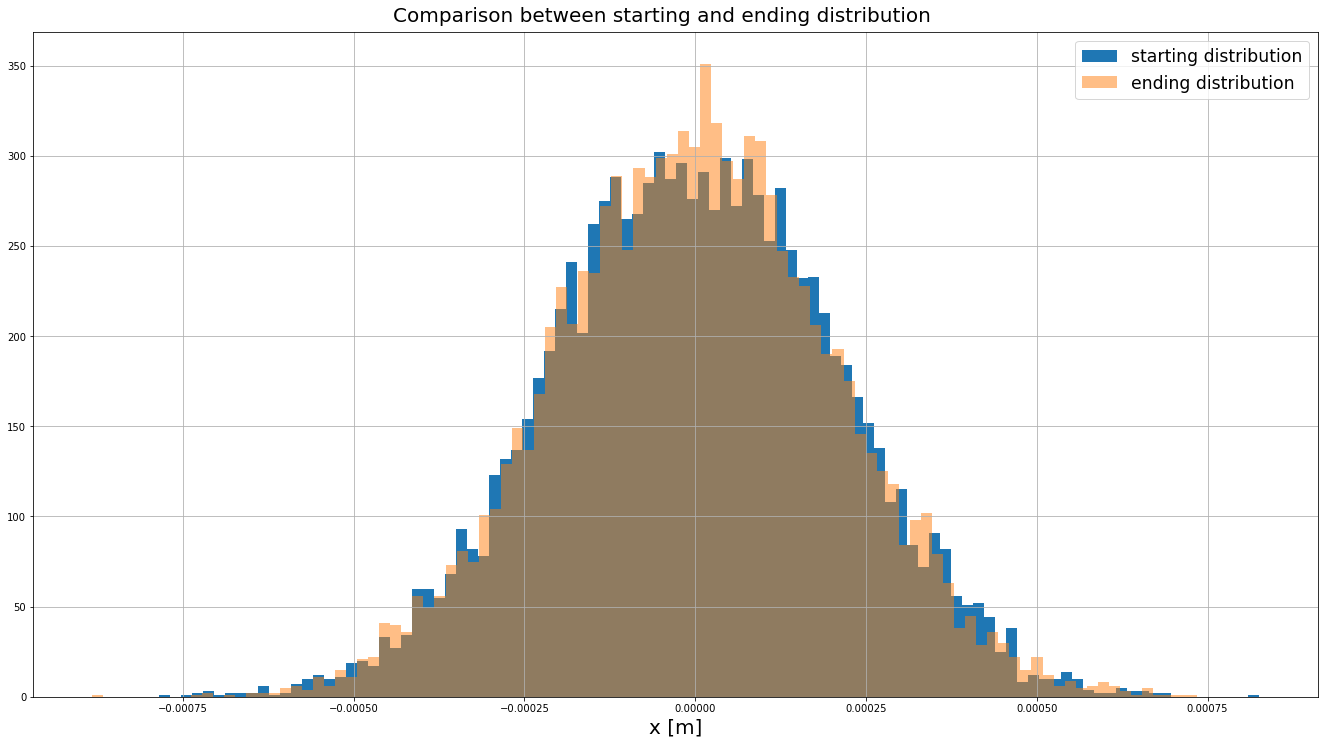

In [17]:
ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
ending_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
ending_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
ending_px = ctx.nparray_from_context_array(gaussian_bunch.px).copy()
ending_py = ctx.nparray_from_context_array(gaussian_bunch.py).copy()
ending_pz = ctx.nparray_from_context_array(gaussian_bunch.pzeta).copy()

fig, ax = plt.subplots(1,1)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Comparison between starting and ending distribution', fontsize = fontsize)
ax.hist(starting_x, bins = 100, label = 'starting distribution')
ax.hist(ending_x, bins = 100, label = 'ending distribution', alpha = 0.5)
ax.set_xlabel('x [m]', fontsize = fontsize)
ax.grid()
ax.legend(fontsize = 'xx-large')
plt.tight_layout()

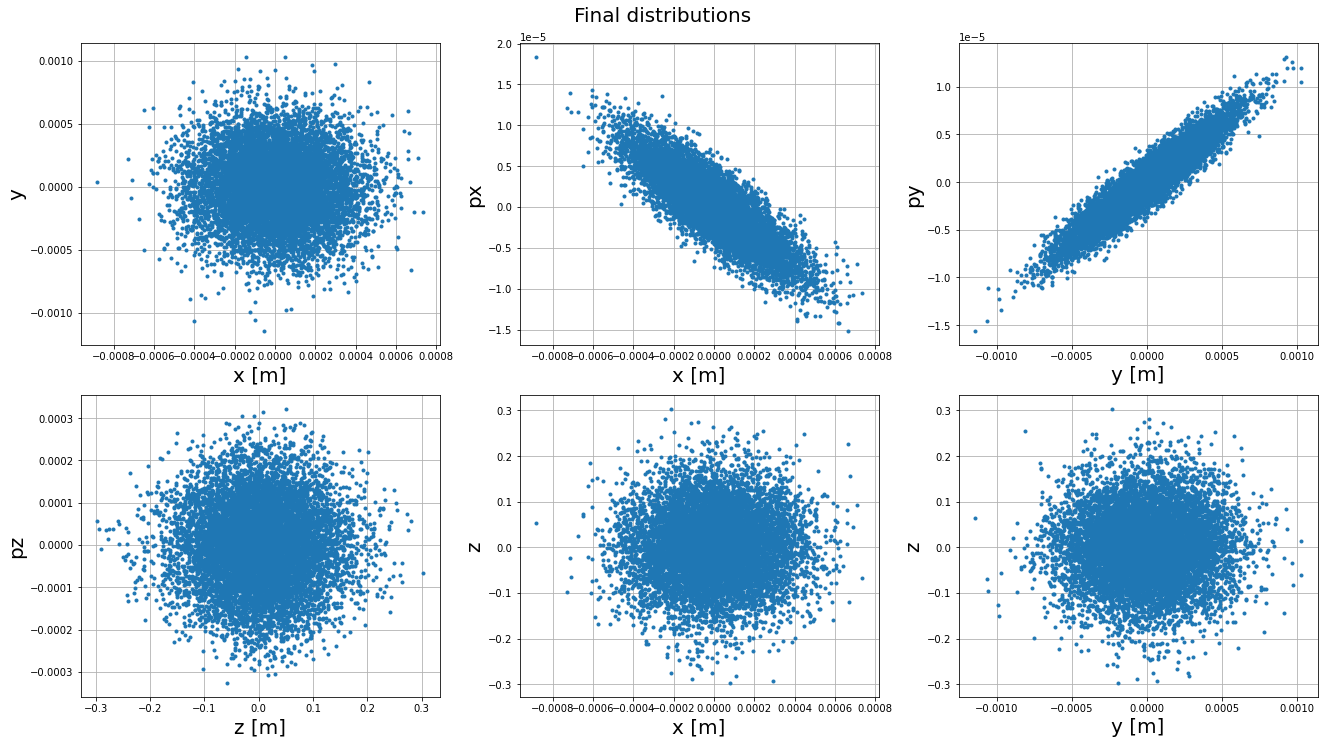

In [18]:
fontsize = 20
fig, ax = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5)
fontsize = 20
fig.suptitle('Final distributions' , fontsize = fontsize)


ending_x = ctx.nparray_from_context_array(gaussian_bunch.x).copy()
ending_y = ctx.nparray_from_context_array(gaussian_bunch.y).copy()
ending_zeta = ctx.nparray_from_context_array(gaussian_bunch.zeta).copy()
ending_px = ctx.nparray_from_context_array(gaussian_bunch.px).copy()
ending_py = ctx.nparray_from_context_array(gaussian_bunch.py).copy()
ending_pz = ctx.nparray_from_context_array(gaussian_bunch.pzeta).copy()


plt.subplot(2,3,1)
plt.plot(ending_x, ending_y, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('y', fontsize = fontsize)
plt.grid()


plt.subplot(2,3,2)
plt.plot(ending_x, ending_px, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('px', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,3)
plt.plot(ending_y, ending_py, '.')
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('py', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,4)
plt.plot(ending_zeta, ending_pz, '.')
plt.xlabel('z [m]', fontsize = fontsize)
plt.ylabel('pz', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,5)
plt.plot(ending_x, ending_zeta, '.')
plt.xlabel('x [m]', fontsize = fontsize)
plt.ylabel('z', fontsize = fontsize)
plt.grid()

plt.subplot(2,3,6)
plt.plot(ending_y, ending_zeta, '.')
plt.xlabel('y [m]', fontsize = fontsize)
plt.ylabel('z', fontsize = fontsize)
plt.grid()




plt.tight_layout()

In [19]:
x_data = collider['lhcb1'].record_last_track.x
y_data = collider['lhcb1'].record_last_track.y
px_data = collider['lhcb1'].record_last_track.px
py_data = collider['lhcb1'].record_last_track.py
zeta_data = collider['lhcb1'].record_last_track.zeta
pz_data = collider['lhcb1'].record_last_track.pzeta
delta_data = collider['lhcb1'].record_last_track.delta
print(x_data.shape)

(10000, 20)


# Gaussian fit for all distributions

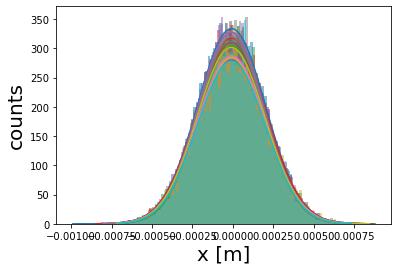

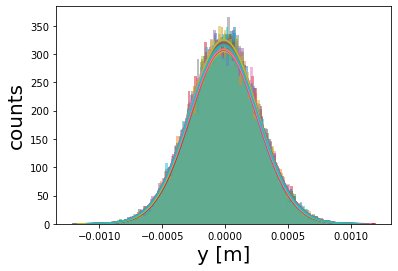

In [20]:
# Gaussian fit and standard deviation

def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

stddev_x = []

for i in range(N_turns):#[16,18]:
    #plt.hist(x_data[:,i*500], bins = 100)
    #hist, bin_edges = np.histogram(x_data[:, i*500], bins = 100)
    hist, bin_edges = np.histogram(x_data[:,  i], bins = 100)
    #print(i)

    counts = hist
    #print(len(counts))
    
    initial_guess = [16., 0., 1e-4]

    fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

    # Extract fitted parameters
    amplitude_fit, mean_fit, stddev_fit = fit_params

    # Generate the fitted Gaussian curve
    y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)
    stddev_x.append(stddev_fit)

    #plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i*500))
    plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i))
    #plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], alpha = 0.5, label = 'Data turn = {}'.format(i*500))
    plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], alpha = 0.5, label = 'Data turn = {}'.format(i))
    
    plt.xlabel('x [m]', fontsize = fontsize)
    plt.ylabel('counts', fontsize = fontsize)
    #plt.legend()
    plt.grid()
    
stddev_y = []
plt.figure()

for i in range(N_turns):
    #plt.hist(x_data[:,i*500], bins = 100)
    #hist, bin_edges = np.histogram(y_data[:, i*500], bins = 100)
    hist, bin_edges = np.histogram(y_data[:, i], bins = 100)
    #print(i*500)

    counts = hist
    #print(len(counts))
    
    initial_guess = [16., 0., 1e-4]

    fit_params, covariance = curve_fit(gaussian, bin_edges[:-1], counts, p0=initial_guess)

    # Extract fitted parameters
    amplitude_fit, mean_fit, stddev_fit = fit_params

    # Generate the fitted Gaussian curve
    y_fit = gaussian(bin_edges[:-1], amplitude_fit, mean_fit, stddev_fit)
    stddev_y.append(stddev_fit)

    #plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i*500))
    plt.plot(bin_edges[:-1], y_fit, label='Gaussian fit turn = {}'.format(i))
    plt.bar(bin_edges[:-1], counts, width=bin_edges[1] - bin_edges[0], alpha = 0.5, label = 'Data turn = {}'.format(i*500))
    plt.xlabel('y [m]', fontsize = fontsize)
    plt.ylabel('counts', fontsize = fontsize)
    #plt.legend()
    plt.grid()
    

#normal_emitt_x = 2.5e-6 #m*rad




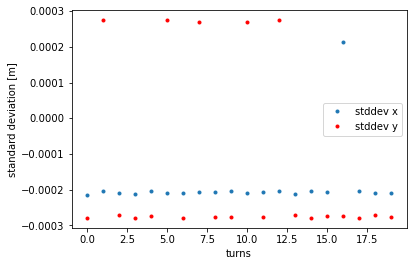

In [21]:
plt.plot(stddev_x, '.', label = 'stddev x')
plt.plot(stddev_y, '.', color = 'red', label = 'stddev y')
plt.xlabel('turns')
plt.ylabel('standard deviation [m]')
plt.legend()


Beta function optical IP1 =  121.39633715003635
Beta relativistic = 0.9999999910167907
Gamma relativistic = 7460.522473526161
Mean emittance fit x =  2.517448576455552e-06
Mean emittance fit y =  2.5481779669539776e-06


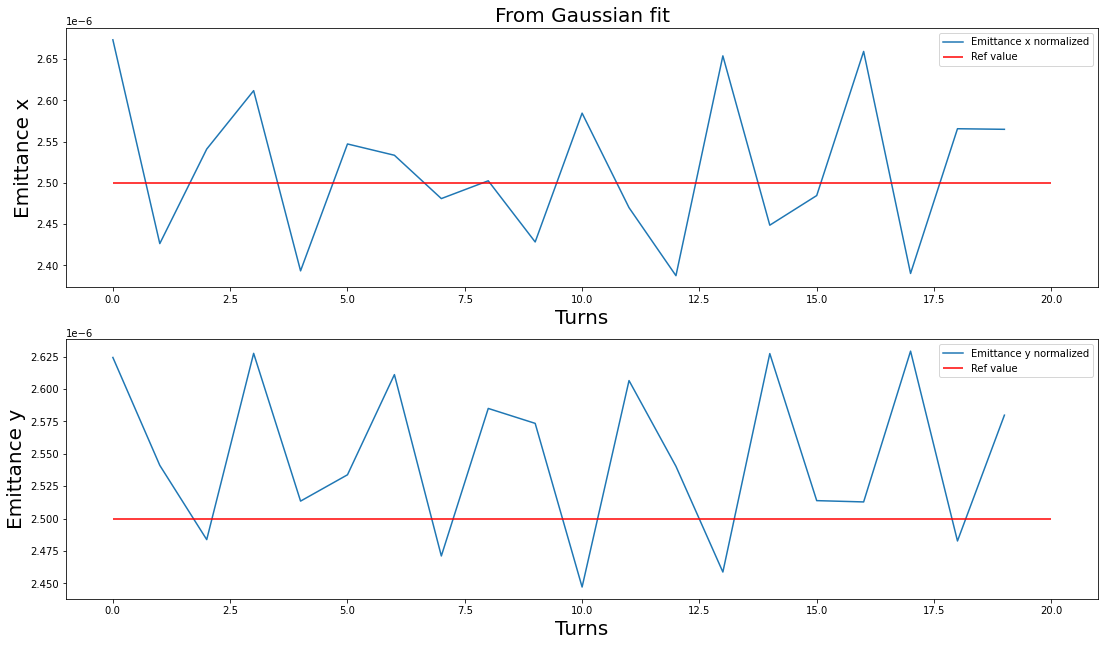

Mean emittance std x =  2.4868509702742986e-06
Mean emittance std y =  2.542473784370096e-06


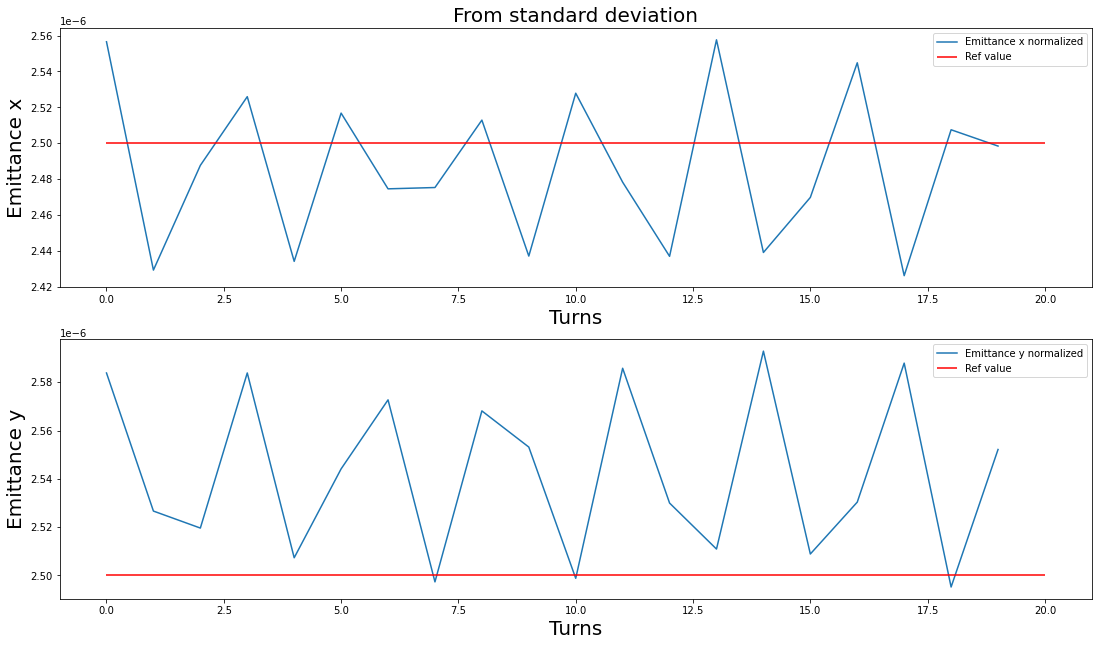

In [22]:
# Emittance calculation, fit and stddev

off_mom = line.particle_ref.delta
betx_optical = twiss_b1.betx[0]

gamma_rel = float(line.particle_ref.gamma0[0])
betx_rel = float(line.particle_ref.beta0[0])

geomx_all = []
normx_all = []
geomy_all = []
normy_all = []
geomx_all_std = []
normx_all_std = []
geomy_all_std = []
normy_all_std = []


print('Beta function optical IP1 = ', betx_optical)
print('Beta relativistic =', betx_rel)
print('Gamma relativistic =', gamma_rel)

sigma_delta: float = float(np.std(gaussian_bunch.delta))

for i in range(N_turns):
    sigma_delta = float(np.std(delta_data[:,i]))
    geomx_emittance = (stddev_x[i]**2-(tw0[:,0]["dx"][0]*sigma_delta)**2)/tw0[:,0]["betx"][0]
    normx_emittance = geomx_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
    geomx_all.append(geomx_emittance)
    normx_all.append(normx_emittance)

    geomy_emittance = (stddev_y[i]**2-(tw0[:,0]["dy"][0]*sigma_delta)**2)/tw0[:,0]["bety"][0]
    normy_emittance = geomy_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
    geomy_all.append(geomy_emittance)
    normy_all.append(normy_emittance)
    
for i in range(N_turns):
    sigma_delta = float(np.std(delta_data[:,i]))
    sigma_x = float(np.std(x_data[:,i]))
    sigma_y = float(np.std(y_data[:,i]))
    
    geomx_emittance = (sigma_x**2-(tw0[:,0]["dx"][0]*sigma_delta)**2)/tw0[:,0]["betx"][0]
    normx_emittance = geomx_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
    geomx_all_std.append(geomx_emittance)
    normx_all_std.append(normx_emittance)

    geomy_emittance = (sigma_y**2-(tw0[:,0]["dy"][0]*sigma_delta)**2)/tw0[:,0]["bety"][0]
    normy_emittance = geomy_emittance*(particle_ref._gamma0[0]*particle_ref._beta0[0])
    geomy_all_std.append(geomy_emittance)
    normy_all_std.append(normy_emittance)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)

plt.subplot(2,1,1)
plt.title('From Gaussian fit', fontsize = fontsize)
plt.plot(np.arange(N_turns), normx_all, label = 'Emittance x normalized')
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance x', fontsize = fontsize)
plt.legend()

print('Mean emittance fit x = ', np.mean(normx_all))
print('Mean emittance fit y = ', np.mean(normy_all))

plt.subplot(2,1,2)
plt.plot(np.arange(N_turns), normy_all, label = 'Emittance y normalized')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance y', fontsize = fontsize)
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.legend()
plt.show()

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.subplot(2,1,1)
plt.title('From standard deviation', fontsize = fontsize)
plt.plot(np.arange(N_turns), normx_all_std, label = 'Emittance x normalized')
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance x', fontsize = fontsize)
plt.legend()

print('Mean emittance std x = ', np.mean(normx_all_std))
print('Mean emittance std y = ', np.mean(normy_all_std))

plt.subplot(2,1,2)

plt.plot(np.arange(N_turns), normy_all_std, label = 'Emittance y normalized')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance y', fontsize = fontsize)
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')

plt.legend()
plt.show()

## Action new emittance calculation

[2.48486858e-06 2.48497189e-06 2.48480547e-06 2.48497215e-06
 2.48488602e-06 2.48465617e-06 2.48464553e-06 2.48452252e-06
 2.48440989e-06 2.48438649e-06 2.48447185e-06 2.48457052e-06
 2.48461910e-06 2.48489425e-06 2.48501583e-06 2.48500888e-06
 2.48519703e-06 2.48508543e-06 2.48492133e-06 2.48485970e-06] [2.54149576e-06 2.54139107e-06 2.54132480e-06 2.54154437e-06
 2.54146608e-06 2.54145140e-06 2.54174271e-06 2.54165959e-06
 2.54168074e-06 2.54193723e-06 2.54179733e-06 2.54180111e-06
 2.54192975e-06 2.54172421e-06 2.54168458e-06 2.54166174e-06
 2.54146215e-06 2.54141990e-06 2.54130099e-06 2.54122693e-06]


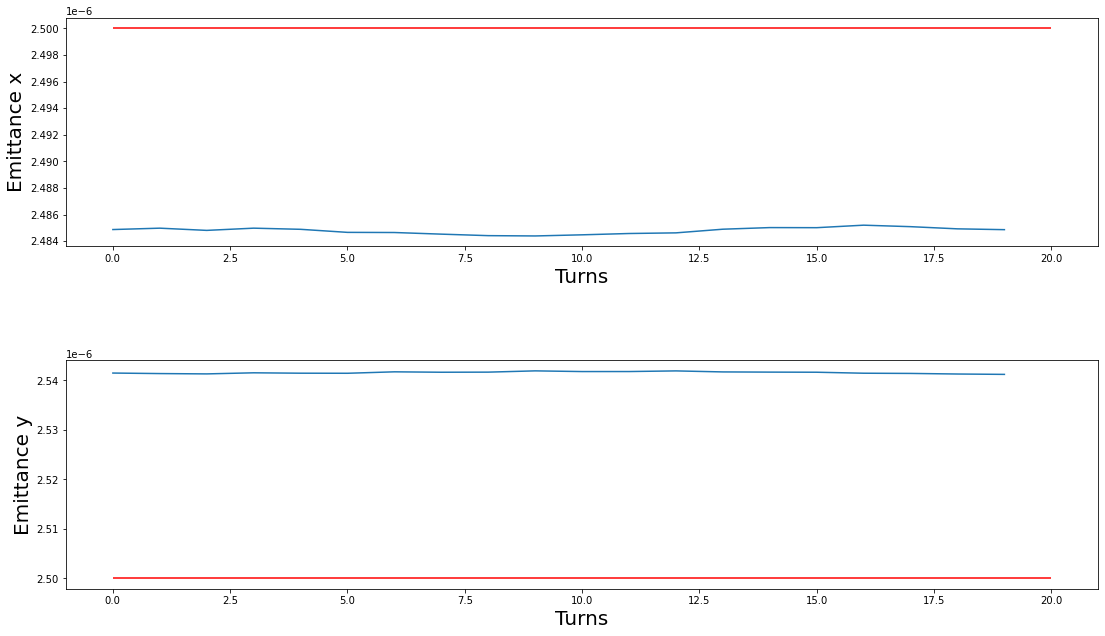

In [23]:
import scipy.constants

# change function 

def emittance_from_action(x, y, px, py, zeta, pzeta):
    x = x_data.T
    y = y_data.T
    px = px_data.T
    py = py_data.T
    zeta = zeta_data.T
    pzeta = pz_data.T

    Jx = np.zeros((N_turns, N_particles))
    Jy = np.zeros((N_turns, N_particles)) 
    errorx = np.zeros(N_turns)
    errory = np.zeros(N_turns)

    betx_rel =particle_ref._beta0[0]
    gamma_rel = particle_ref._gamma0[0]
    W = line.twiss()['W_matrix'][0]

    W_inv = np.linalg.inv(W)
    tw_full_inverse = line.twiss(use_full_inverse=True)['W_matrix'][0]

    n_repetitions = x.shape[0]
    n_particles = x.shape[1]

    inv_w = W_inv

    phys_coord = np.array([x,px,y,py,zeta,pzeta])
    phys_coord = phys_coord.astype(float)
    phys_coord[phys_coord==0.]=np.nan
    norm_coord = np.zeros_like(phys_coord)
    for i in range(n_repetitions):
        norm_coord[:,i,:] = np.matmul(inv_w, (phys_coord[:,i,:]))

    for i in range(N_turns):
        Jx[i,:] = (pow(norm_coord[0, i, :],2)+pow(norm_coord[1, i, :],2))/2 
        Jy[i,:] = (pow(norm_coord[2, i, :],2)+pow(norm_coord[3, i, :],2))/2 

    emitx = np.nanmean(Jx, axis=1)*(betx_rel*gamma_rel)
    emity = np.nanmean(Jy, axis=1)*(betx_rel*gamma_rel)
    return emitx, emity

x = x_data.T
y = y_data.T
px = px_data.T
py = py_data.T
zeta = zeta_data.T
pzeta = pz_data.T

Jx = np.zeros((N_turns, N_particles))
Jy = np.zeros((N_turns, N_particles)) 
errorx = np.zeros(N_turns)
errory = np.zeros(N_turns)

betx_rel =particle_ref._beta0[0]
gamma_rel = particle_ref._gamma0[0]
W = line.twiss()['W_matrix'][0]

W_inv = np.linalg.inv(W)
tw_full_inverse = line.twiss(use_full_inverse=True)['W_matrix'][0]

n_repetitions = x.shape[0]
n_particles = x.shape[1]

inv_w = W_inv

phys_coord = np.array([x,px,y,py,zeta,pzeta])
phys_coord = phys_coord.astype(float)
phys_coord[phys_coord==0.]=np.nan
norm_coord = np.zeros_like(phys_coord)
for i in range(n_repetitions):
    norm_coord[:,i,:] = np.matmul(inv_w, (phys_coord[:,i,:]))

for i in range(N_turns):
    Jx[i,:] = (pow(norm_coord[0, i, :],2)+pow(norm_coord[1, i, :],2))/2 
    Jy[i,:] = (pow(norm_coord[2, i, :],2)+pow(norm_coord[3, i, :],2))/2 

emitx = np.nanmean(Jx, axis=1)*(betx_rel*gamma_rel)
emity = np.nanmean(Jy, axis=1)*(betx_rel*gamma_rel)

print(emitx, emity)

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.subplot(2,1,1)
plt.plot(emitx, label = 'Emittance x from action')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance x', fontsize = fontsize)
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.subplots_adjust(hspace = 0.5)
plt.subplot(2,1,2)
plt.plot(emity, label = 'Emittance y from action')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance y', fontsize = fontsize)
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')

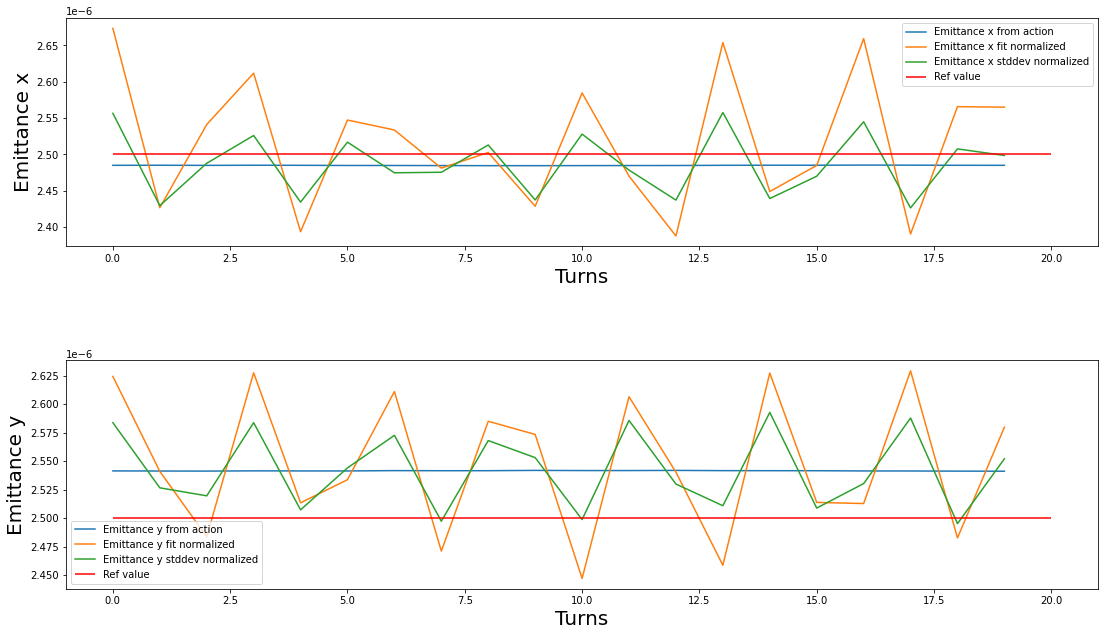

In [24]:
# All methods together

fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.subplot(2,1,1)
plt.plot(emitx, label = 'Emittance x from action')
plt.plot(np.arange(N_turns), normx_all, label = 'Emittance x fit normalized')
plt.plot(np.arange(N_turns), normx_all_std, label = 'Emittance x stddev normalized')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance x', fontsize = fontsize)
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.subplots_adjust(hspace = 0.5)
plt.legend()

plt.subplot(2,1,2)
plt.plot(emity, label = 'Emittance y from action')
plt.plot(np.arange(N_turns), normy_all, label = 'Emittance y fit normalized')
plt.plot(np.arange(N_turns), normy_all_std, label = 'Emittance y stddev normalized')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance y', fontsize = fontsize)
plt.hlines(2.5e-6, xmin = 0 , xmax = N_turns, colors = 'red', label = 'Ref value')
plt.legend()


# Functions for emittance computation

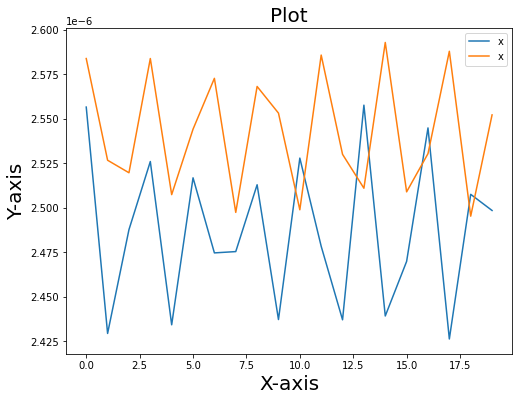

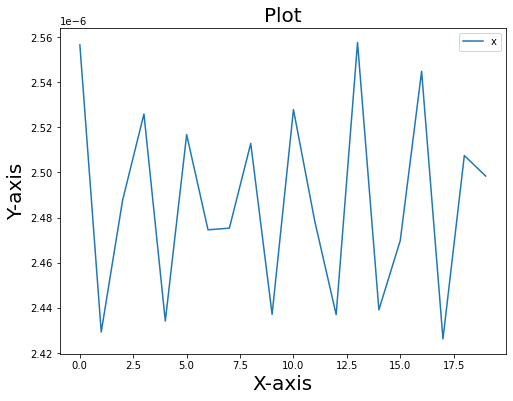

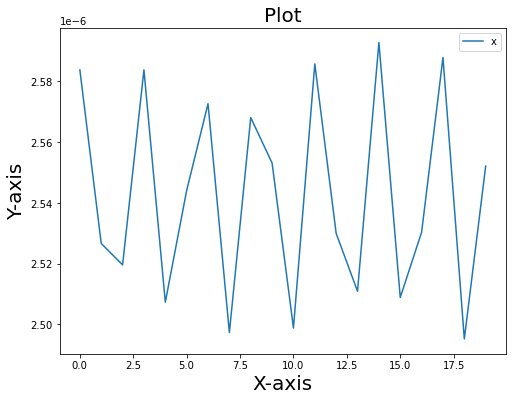

In [25]:
def get_geom_emit_from_sigma(sigma_, sigma_delta, beta_optics, dispersion):
    return (sigma_**2-(dispersion*sigma_delta)**2)/beta_optics

def get_normalized_emit_from_geom(emit_geom, gamma_rel, beta_rel):
    return emit_geom*gamma_rel*beta_rel
    
def get_statistical_emit(x,y, delta, twiss):
    sigma_x = float(np.std(x))
    sigma_y = float(np.std(y))
    sigma_delta = float(np.std(delta))
    
    geom_emittance_x = get_geom_emit_from_sigma(sigma_x, sigma_delta, twiss[:,0]["betx"][0], twiss[:,0]["dx"][0])
    geom_emittance_y = get_geom_emit_from_sigma(sigma_y, sigma_delta, twiss[:,0]["bety"][0], twiss[:,0]["dy"][0])
    norm_emittance_x = get_normalized_emit_from_geom(geom_emittance_x, particle_ref._gamma0[0],particle_ref._beta0[0])
    norm_emittance_y = get_normalized_emit_from_geom(geom_emittance_y, particle_ref._gamma0[0],particle_ref._beta0[0])
    
    return norm_emittance_x, norm_emittance_y

emitxy_statfunc = []
for i in range(N_turns):
    emitxy = get_statistical_emit(x_data[:,i], y_data[:,i], delta_data[:,i], tw0)
    emitxy_statfunc.append(emitxy)
    
def plot_data(x, y=None, xlabel='X-axis', ylabel='Y-axis', title='Plot'):
    """
    Plot x vs y if y is provided, otherwise plot x.

    Parameters:
    - x: Array for the X-axis.
    - y: Array for the Y-axis (optional).
    - xlabel: Label for the X-axis (default: 'X-axis').
    - ylabel: Label for the Y-axis (default: 'Y-axis').
    - title: Plot title (default: 'Plot').
    """
    plt.figure(figsize=(8, 6))
    fontsize = 20

    if y is not None and len(x) > 0 and len(y) > 0:
        plt.plot(x, y, label='x vs y')
    elif len(x) > 0:
        plt.plot(x, label='x')

    plt.xlabel(xlabel, fontsize = fontsize)
    plt.ylabel(ylabel, fontsize = fontsize)
    plt.title(title, fontsize = fontsize)
    plt.legend()
    plt.show()
    
plot_data(emitxy_statfunc)
    
#plt.plot(emitxy_statfunc)

plot_data(np.array(emitxy_statfunc).T[0 ])
plot_data(np.array(emitxy_statfunc).T[1])


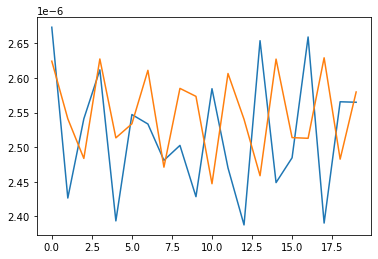

In [26]:
def get_statistical_emit_form_fit(x, y, delta, twiss):
    
    sigma_delta = float(np.std(delta))
    geom_emittance_x = get_geom_emit_from_sigma(x, sigma_delta, twiss[:,0]["betx"][0], twiss[:,0]["dx"][0])
    geom_emittance_y = get_geom_emit_from_sigma(y, sigma_delta, twiss[:,0]["bety"][0], twiss[:,0]["dy"][0])
    norm_emittance_x = get_normalized_emit_from_geom(geom_emittance_x, particle_ref._gamma0[0],particle_ref._beta0[0])
    norm_emittance_y = get_normalized_emit_from_geom(geom_emittance_y, particle_ref._gamma0[0],particle_ref._beta0[0])
    
    return norm_emittance_x, norm_emittance_y


emitxy_fit = []
for i in range(N_turns):
    emitxy = get_statistical_emit_form_fit(stddev_x[i], stddev_y[i], delta_data[:, 0], tw0)
    emitxy_fit.append(emitxy)
    
plt.plot(emitxy_fit)

## Action old

In [ ]:
import scipy.constants
W = line.twiss()['W_matrix'][0]
print(W)
W_inv = np.linalg.inv(W)
tw_full_inverse = line.twiss(use_full_inverse=True)['W_matrix'][0]
print(tw_full_inverse)


array_6D = np.array([x_data.tolist(), y_data.tolist(), px_data.tolist(), py_data.tolist(), zeta_data.tolist(), pz_data.tolist()])

array_6D.shape
array_6D_norm = np.zeros_like(array_6D)
print(array_6D_norm.shape)


for i in range(N_particles):
    for j in range(N_turns):
        norm = tw_full_inverse @ array_6D[:,i,j]
        array_6D_norm[:,i,j] = norm

array_6D_norm.shape


Jx = np.zeros((N_turns, N_particles))
Jy = np.zeros((N_turns, N_particles)) 
errorx = np.zeros(N_turns)
errory = np.zeros(N_turns)
num_repetitions = 1

for i in range(N_turns):
    Jx[i,:] = (pow(array_6D_norm[0,:, i],2)+pow(array_6D_norm[2, :, i],2))/2 
    Jy[i,:] = (pow(array_6D_norm[1,:, i],2)+pow(array_6D_norm[3, :, i],2))/2
    num_particles_at_turn = N_particles 
    errorx[i] = np.nanstd(Jx[i])/(np.sqrt(num_particles_at_turn))*(betx_rel*gamma_rel)
    errory[i] = np.nanstd(Jy[i])/(np.sqrt(num_particles_at_turn))*(betx_rel*gamma_rel)




#x_axis = np.linspace(1, N_turns, N_turns)
#_axis = x_axis*26000/(scipy.constants.c*60)

emitx = np.nanmean(Jx, axis=1)*(betx_rel*gamma_rel)
emity = np.nanmean(Jy, axis=1)*(betx_rel*gamma_rel)

plt.plot(emitx*1e6, '.')
#plt.plot(emity*1e6, '.')
plt.xlabel('Number of turns ')
plt.ylabel('Emittance $\epsilon$ $\mu$[m]')
plt.legend(['$\epsilon_x$', '$\epsilon_y$'])
plt.xlim(0,10)
plt.show()


## Emmitance one snapshot


In [ ]:
# Emittance
emit_x_all = []
for i in range(len(x_data.T)):

    rms_x = np.sqrt(np.mean(x_data.T[i]**2))
    rms_y = np.sqrt(np.mean(y_data.T[i]**2))
    rms_z = np.sqrt(np.mean(zeta_data.T[i]**2))
    rms_px = np.sqrt(np.mean(px_data.T[i]**2))
    rms_py = np.sqrt(np.mean(py_data.T[i]**2))
    rms_pz = np.sqrt(np.mean(pz_data.T[i]**2))



    cov_matrix_x = np.cov(x_data.T[i], px_data.T[i])
    cov_matrix_y = np.cov(y_data.T[i], py_data.T[i])
    cov_matrix_z = np.cov(zeta_data.T[i], pz_data.T[i])
    cross_term_x = cov_matrix_x[0,1]
    cross_term_y = cov_matrix_y[0, 1]
    cross_term_z = cov_matrix_z[0, 1]
    # Compute the emittance using RMS values and the cross-correlation term
    emit_x = np.sqrt(rms_x ** 2 * rms_px ** 2 - cross_term_x ** 2)
    emit_y = np.sqrt(rms_y ** 2 * rms_py ** 2 - cross_term_y ** 2)
    emit_z = np.sqrt(rms_z ** 2 * rms_pz ** 2 - cross_term_z ** 2)

    emit_x_all.append(emit_x)
    
    print(rms_x, rms_px, emit_x)

plt.plot(emit_x_all, '.')
len(emit_x_all)



In [ ]:
dx = collider.lhcb1.twiss().to_pandas().iloc[0]["dx"]
dy = collider.lhcb1.twiss().to_pandas().iloc[0]["dy"]



In [ ]:
import numpy as np

# Assuming x_data, y_data, z_data, px_data, py_data, pz_data are arrays/lists containing respective data
emittance_x_all = []
emittance_y_all = []
emittance_z_all = []
total_all = []
# Calculate mean values for x, y, z, px, py, pz
for i in range(len(x_data.T)):
    mean_x = np.mean(x_data.T[i])
    mean_y = np.mean(y_data.T[i])
    mean_z = np.mean(zeta_data.T[i])
    mean_px = np.mean(px_data.T[i])
    mean_py = np.mean(py_data.T[i])
    mean_pz = np.mean(pz_data.T[i])

    # Calculate RMS values for x, y, z, px, py, pz
    rms_x = np.sqrt(np.mean(np.square(x_data.T[i])))
    rms_y = np.sqrt(np.mean(np.square(y_data.T[i])))
    rms_z = np.sqrt(np.mean(np.square(zeta_data.T[i] - mean_z)))
    rms_px = np.sqrt(np.mean(np.square(px_data.T[i])))
    rms_py = np.sqrt(np.mean(np.square(py_data.T[i])))
    rms_pz = np.sqrt(np.mean(np.square(pz_data.T[i] - mean_pz)))

    # Calculate the covariance matrix for position and momentum
    data_matrix = np.array([x_data.T[i], y_data.T[i], zeta_data.T[i], px_data.T[i], py_data.T[i], pz_data.T[i]])
    cov_matrix = np.cov(data_matrix)
    print('If determinant = 0, a singularity.. problematic check data: det = ', np.linalg.det(cov_matrix))
    #plt.plot(np.linalg.det(cov_matrix), '.')
    

    # Extract the covariance terms between different dimensions
    cov_x_px = cov_matrix[0, 3]  # Covariance between x and px
    

    cov_y_py = cov_matrix[1, 4]  # Covariance between y and py
    cov_z_pz = cov_matrix[2, 5]  # Covariance between z and pz
    print(cov_x_px, cov_y_py, cov_z_pz)

    dispersion_contribution_x = np.square(D1) * rms_x ** 2
    print('disp contr', np.sqrt(rms_py**2*rms_y**2-cov_y_py**2)*gamma_rel*betx_rel)


    # Compute emittance in each direction
    emittance_x = np.sqrt(rms_x ** 2 * rms_px ** 2 - cov_x_px ** 2)
    emittance_y = np.sqrt(rms_y ** 2 * rms_py ** 2 - cov_y_py ** 2)
    #emittance_z = np.sqrt(rms_z ** 2 * rms_pz ** 2 - cov_z_pz ** 2)
    #total_emittance = np.sqrt(rms_x ** 2 * rms_px ** 2 - cov_x_px ** 2) * np.sqrt(rms_y ** 2 * rms_py ** 2 - cov_y_py ** 2)#* np.sqrt(rms_z ** 2 * rms_pz ** 2 - cov_z_pz ** 2)

    emittance_x_all.append(emittance_x*gamma_rel*betx_rel)
    emittance_y_all.append(emittance_y*gamma_rel*betx_rel)
    #emittance_z_all.append(emittance_z)
    
    #total_all.append(total_emittance)


print("Emittance in x-direction:", np.mean(emittance_x_all))
print("Emittance in y-direction:", np.mean(emittance_y_all))
#print("Emittance in z-direction:", emittance_z)


plt.figure(figsize=(15, 5))
plt.subplot(3,1,1)
plt.xlabel('Turns')
plt.ylabel('Emittance x')
plt.plot(emittance_x_all, '.')
plt.subplots_adjust(hspace=0.5)
plt.subplot(3,1,2)
plt.plot(emittance_y_all, '.')
plt.xlabel('Turns')
plt.ylabel('Emittance y')
'''
plt.subplot(3,1,3)
plt.plot(total_emittance, '.')
plt.xlabel('Turns')
plt.ylabel('Emittance total')
'''

print(line.twiss().dx)  #dx: horizontal dispersion (d x / d delta) in meters

In [ ]:
import PyNAFF
qx_i = []
qy_i = []
for ii in range(len(x_data.T[0])):
    qx_i.append(PyNAFF.naff(x_data[ii,:], turns=N_turns-1)[0][1])
    qy_i.append(PyNAFF.naff(y_data[ii,:], turns=N_turns-1)[0][1])

In [ ]:
filtered_values_x = list(filter(lambda x: x > 0.2, qx_i))
filtered_values_y = list(filter(lambda x: x > 0.2, qy_i))
#plt.plot(filtered_values_x, filtered_values_y)
indices_x = [i for i, val in enumerate(qx_i) if val > 0.2]
indices_y = [i for i, val in enumerate(qy_i) if val > 0.2]

print("Indices for filtered_values_x:", indices_x)
print("Indices for filtered_values_y:", indices_y)

print('Tune x:', np.mean(filtered_values_x))
print('Tune y:', np.mean(filtered_values_y))
common_indices = list(set(indices_x).intersection(indices_y))

values_from_qx_i = [qx_i[idx] for idx in common_indices]

values_from_qy_i = [qy_i[idx] for idx in common_indices]
plt.plot(values_from_qx_i, values_from_qy_i)
plt.xlim(0.28, 0.36)
plt.ylim(0.28, 0.36)

In [ ]:
fp0_jgrid = collider['lhcb1'].get_footprint(nemitt_x=normal_emitt_x, nemitt_y=normal_emitt_y,
                            mode='polar')
fp0_jgrid.plot(color='red')

In [ ]:
len(zeta_data.T)
std_x = np.std(x_data.T[0])
std_y = np.std(y_data.T[0])
std_z = np.std(zeta_data.T[0])
std_px = np.std(px_data.T[0])
std_py = np.std(py_data.T[0])
std_pz = np.std(pz_data.T[0])

cov_x_xp = np.cov(x_data.T[0], px_data.T[0])[0][1]
cov_y_yp = np.cov(y_data.T[0], py_data.T[0])[0][1]
cov_z_zp = np.cov(zeta_data.T[0], pz_data.T[0])[0][1]
cov_x_z = np.cov(x_data.T[0], zeta_data.T[0])[0][1]
cov_y_z = np.cov(y_data.T[0], zeta_data.T[0])[0][1]
cov_pz_py = np.cov(pz_data.T[0], py_data.T[0])[0][1]

# Emittance
emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)
print('Emmitance: ', emitt)


In [ ]:
emitt_all = []
for i in range(len(x_data.T)):
    std_x = np.std(x_data.T[i])
    std_y = np.std(y_data.T[i])
    std_z = np.std(zeta_data.T[i])
    std_px = np.std(px_data.T[i])
    std_py = np.std(py_data.T[i])
    std_pz = np.std(pz_data.T[i])

    # That is for the correlation between the planes
    cov_x_xp = np.cov(x_data.T[i], px_data.T[i])[0][1]   
    cov_x_z = np.cov(x_data.T[i], zeta_data.T[i])[0][1]
    cov_y_z = np.cov(y_data.T[i], zeta_data.T[i])[0][1]

    # Emittance
    emitt  = np.sqrt(std_x**2*std_px**2 - cov_x_xp**2 + std_y**2*std_py**2 - cov_x_xp**2 + std_z**2*std_pz**2 - cov_x_xp**2)
    emitt_all.append(emitt)

plt.plot(emitt_all, '.')
plt.xlabel('Turns', fontsize = fontsize)
plt.ylabel('Emittance $\epsilon $', fontsize = fontsize)

In [ ]:

plt.plot(zeta_data[0], pz_data[0].T, '.')
plt.plot(zeta_data[1], pz_data[1].T, '.')

print(len(x_data)-1)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Generating example data (replace this with your actual data)
num_points = 100
num_snapshots = 10
x_min = min(x_data.flatten())
x_max = max(x_data.flatten())
px_min = min(px_data.flatten())
px_max = max(px_data.flatten())
y_min = min(y_data.flatten())
y_max = max(y_data.flatten())
py_min = min(py_data.flatten())
py_max = max(py_data.flatten())
z_min = min(zeta_data.flatten())
z_max = max(zeta_data.flatten())
pz_min = min(pz_data.flatten())
pz_max = max(pz_data.flatten())



# Plot and save each frame as an image
images = []
for i in range(len(x_data[:])):
    plt.plot(zeta_data.T[i], pz_data.T[i], '.')
    plt.title(f"Turn {i}")
    plt.xlabel('z [m]')
    plt.ylabel('pz')
    plt.savefig(f"images/frame_{i}.png")  # Save each frame as an image
    plt.clf()  # Clear the plot for the next frame
    plt.xlim(z_min, z_max)
    plt.ylim(pz_min, pz_max)
    # Open the saved image and append it to the list of images
    img = Image.open(f"images/frame_{i}.png")
    images.append(img)

# Save the images as an animated GIF
images[0].save('animation_zeta_pz_1000turns_time.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)
